In [38]:
import pandas as pd
# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
df = pd.read_csv('./dataset/scrapped_data.csv')

## BERT

In [7]:
from transformers import BertTokenizer, BertModel
import torch

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Sample texts
texts = [
    "Extracting embeddings from BERT is straightforward.",
    "BERT stands for Bidirectional Encoder Representations from Transformers."
]

# Tokenize inputs
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)

# Get embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Mean pooling
mean_embeddings = torch.mean(outputs.last_hidden_state, dim=1)

print("Embeddings shape:", mean_embeddings.shape)

/home/kanhon/anaconda3/envs/cs5284_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embeddings shape: torch.Size([2, 768])


In [8]:
def get_bert_embedding(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Mean pooling
    attention_mask = inputs['attention_mask']
    token_embeddings = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    mean_embedding = sum_embeddings / sum_mask
    
    return mean_embedding.squeeze().cpu().numpy()  # Convert to numpy array


In [10]:
# get_bert_embedding('Second-term Democratic U.S. President Jackson .')
inputs

{'input_ids': tensor([[  101, 14817,  2075,  7861,  8270,  4667,  2015,  2013, 14324,  2003,
         19647,  1012,   102,     0,     0,     0],
        [  101, 14324,  4832,  2005,  7226,  7442,  7542,  2389,  4372, 16044,
          2099, 15066,  2013, 19081,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [13]:
text = 'Second-term Democratic U.S. President Jackson .'
inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Get the embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Mean pooling
attention_mask = inputs['attention_mask']
token_embeddings = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
mean_embedding = sum_embeddings / sum_mask


In [17]:
token_embeddings.shape

torch.Size([1, 13, 768])

In [18]:
input_mask_expanded.shape

torch.Size([1, 13, 768])

In [19]:
sum_embeddings.shape

torch.Size([1, 768])

In [25]:
outputs = model(inputs['input_ids'], attention_mask=attention_mask)

_, preds = torch.max(outputs, dim=1)

TypeError: max() received an invalid combination of arguments - got (BaseModelOutputWithPoolingAndCrossAttentions, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [26]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.1222, -0.2645, -0.7754,  ..., -0.5312,  0.5358,  0.4180],
         [-0.5025, -0.7909, -0.1650,  ...,  0.2238,  0.2938, -0.2488],
         [-0.2151, -0.1618, -0.4851,  ...,  0.3470, -0.5996,  0.2346],
         ...,
         [-1.1010, -0.3421, -0.6992,  ..., -1.1100, -0.2749,  1.3164],
         [-0.7988, -0.8583, -0.6478,  ...,  0.5003,  0.4374, -0.2942],
         [-0.3523, -0.0112, -1.0602,  ..., -0.3959, -0.6608,  0.5250]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8689, -0.4991, -0.8062,  0.7210,  0.6703, -0.2815,  0.7502,  0.3937,
         -0.6515, -1.0000, -0.5447,  0.9519,  0.9832,  0.0764,  0.8581, -0.7974,
         -0.4934, -0.6065,  0.2962, -0.3783,  0.5293,  1.0000, -0.0171,  0.3378,
          0.4708,  0.9694, -0.7096,  0.8560,  0.9668,  0.8010, -0.4805,  0.4260,
         -0.9918, -0.1937, -0.7728, -0.9896,  0.5600, -0.7084, -0.0061, -0.1659,
         -0.770

In [35]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')  # You can choose different pre-trained models

# Example sentences
sentences = [
    "This is an example sentence. Each sentence is converted into a fixed-size vector.",
    "Each sentence is converted into a fixed-size vector.",
    "Sentence transformers make it easy to get sentence embeddings."
]

# Generate embeddings for the sentences
embeddings = model.encode(sentences)

# Print the embeddings
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embeddings[i][:5]}...")  # Print first 5 elements of the embedding for brevity
    print()

Sentence: This is an example sentence. Each sentence is converted into a fixed-size vector.
Embedding: [ 0.04839058 -0.04085585 -0.02612372  0.04525339 -0.01193509]...

Sentence: Each sentence is converted into a fixed-size vector.
Embedding: [ 0.05137224 -0.04172549 -0.02310139  0.07571389 -0.02203474]...

Sentence: Sentence transformers make it easy to get sentence embeddings.
Embedding: [-0.01584433  0.0516122  -0.01202646  0.05389441 -0.03024017]...



In [36]:
embeddings.shape

(3, 768)

## GeminiAPI

In [40]:
from utils.bert_embeddings import *
from utils.gemini_api import *
import time
from tqdm import tqdm

In [41]:
df['Plot'] = df['Plot'].fillna(df['Title'])

In [42]:
# df = df.head(30)

In [43]:
gem = GeminiAPI()

In [44]:
# Initialize an empty list to store the summarized plots
summarised_plots = []

# Iterate over each row in the DataFrame
for index, row in tqdm(df.iterrows()):
    plot = row['Plot']  # Get the 'Plot' column value
    try:
        summarised_plot = gem.inference(plot)  # Call the inference method on the plot
        summarised_plots.append(summarised_plot)  # Append the result to the list
        if index % 100 == 0:
            print(summarised_plot)
        # time.sleep(1)
    except Exception as e:
        print(f'ERROR {e} in {row["Title"]}')
        summarised_plots.append(None)
# Assign the summarized plots to a new column in the DataFrame
df['Summarised_Plot'] = summarised_plots


1it [00:02,  2.79s/it]

In "Toy Story," a group of sentient toys led by Sheriff Woody face a crisis when Andy, their owner, is getting a new toy for his birthday. Woody fears being replaced, especially by the new Buzz Lightyear action figure who believes he's a real Space Ranger. Jealousy and misunderstandings lead to a series of events, including Buzz falling out of the window and Woody being blamed.

Their adventures take them to Pizza Planet, where they encounter Andy's neighbor, Sid, who tortures toys. Buzz experiences an existential crisis upon realizing he's not a real Space Ranger, but Woody helps him find purpose in making Andy happy.

After Sid tries to blow up Buzz with a firework, Woody and Buzz escape and chase after Andy's moving truck. Woody gets inside, but the other toys, still thinking he's dangerous, throw him out.  Woody and Buzz eventually reunite and make it to the new house, where Andy welcomes a new puppy. While Woody and Buzz playfully ponder what new toy could be worse than Buzz, they

25it [00:43,  1.31s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Leaving Las Vegas (1995)


49it [01:21,  1.24s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in When Night Is Falling (1995)


63it [01:43,  1.21s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)


85it [02:17,  1.07s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Angels and Insects (1995)


101it [02:42,  1.66s/it]

Martha, a 31-year-old woman, finds herself in a Mexican prison, accused of murdering her fiancé, Whitman Crawford, on their wedding day. She recounts how she met Whitman, a charming and seemingly successful man who quickly won over her family. However, his true nature as a manipulative and narcissistic sociopath soon becomes apparent. 

Whitman's ex-girlfriend, Inga, and her accomplice, Bob, harass Martha after she tries to break off the engagement. Whitman's lies and manipulations leave Martha isolated and desperate.  He sabotages her job, physically assaults her, and ultimately abducts her to Mexico for a forced wedding. 

Martha manages to contact her co-worker Walter, the only person who hasn't fallen under Whitman's spell. Walter arrives in Mexico just as Whitman is forcing Martha into the ceremony.  During a chaotic rescue attempt, Whitman is shot, and Martha is arrested for murder.  

It is later revealed that Inga accidentally shot Whitman while trying to kill Martha. Walter he

110it [02:57,  1.32s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Taxi Driver (1976)


120it [03:12,  1.61s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Boys of St. Vincent, The (1993)


174it [04:39,  1.31s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Kids (1995)


179it [04:44,  1.01s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Mallrats (1995)


192it [05:04,  1.10s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Showgirls (1995)


201it [05:18,  1.65s/it]

The film explores the tumultuous relationship between poets Paul Verlaine and Arthur Rimbaud. It begins with an older Verlaine encountering Rimbaud's sister, who seeks to destroy his brother's poems. Verlaine reminisces about their passionate, destructive connection, which began when a teenage Rimbaud sent his poetry to Verlaine. Verlaine was captivated by Rimbaud's rebellious spirit and unconventional talent, leading him to abandon his comfortable, middle-class life and embark on a chaotic journey with the younger poet.

Their love affair was marked by violence and instability, culminating in a shooting incident that landed Verlaine in prison. While incarcerated, Verlaine found solace in religion, a change that alienated Rimbaud. Despite their tumultuous past, they briefly reunite, but their relationship ultimately ends, leaving Verlaine yearning for the lost connection. 

Rimbaud, disillusioned by literature, embarks on a solitary journey, seeking a life devoid of artistic expression

228it [06:02,  1.20s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Dolores Claiborne (1994)


297it [08:01,  1.46s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Priest (1994)


301it [08:08,  1.60s/it]

In the lawless town of Redemption, ruled by the ruthless mayor John Herod, a deadly single-elimination shooting tournament is held. "The Lady," a mysterious gunslinger with a dark past, enters the tournament for the hefty prize money.  

Herod's henchmen force Cort, a former outlaw turned preacher, to participate, but The Lady intervenes, saving him.  She also meets "The Kid," a young man who believes Herod is his father and wants his approval.

The tournament unfolds with deadly duels, including The Lady's confrontation with a man who abuses a child, and Cort's struggle against a skilled Native American gunslinger.  

Flashbacks reveal The Lady's true identity as Ellen, whose father was murdered by Herod's gang. Driven by revenge, she returns to Redemption.  

Herod manipulates the tournament, forcing Cort to fight The Lady and then The Kid, ultimately killing the young man. Ellen, faking her death, plans revenge with Cort and Doc Wallace. 

In a final showdown, Ellen reveals her iden

401it [10:47,  1.44s/it]

Malcolm X, a young black man from Michigan, faces racism and tragedy early in life. His father is murdered, his mother institutionalized, and his dreams of being a lawyer are crushed. He falls into a life of crime, eventually ending up in prison. There, he finds solace in the teachings of the Nation of Islam and embraces their message of black empowerment and separation from white society. 

He rises within the Nation, becoming a powerful and charismatic leader.  However, Malcolm's disillusionment grows as he discovers inconsistencies in Elijah Muhammad's teachings, and he begins to question the Nation's ideology. 

After a pilgrimage to Mecca, Malcolm renounces the Nation of Islam's separatist views, embracing a more inclusive form of Islam and founding the Organization of Afro-American Unity. He is exiled from the Nation and his house is firebombed. 

Tragically, Malcolm is assassinated by members of the Nation of Islam in 1965, leaving behind a legacy of fighting for equality and ch

501it [13:33,  1.76s/it]

John Robbins, a wrongfully convicted ex-Marine, is imprisoned in a Level 6 prison, a brutal facility run by corporations. He is exiled to Absolom, a remote island prison where the worst criminals are sent. The island is ruled by the Outsiders, a ruthless gang led by the sociopath Walter Marek, who forces prisoners to fight for survival. Robbins joins the Insiders, a group striving for order and cooperation led by a dying doctor called the Father.  

Robbins learns about the island's horrifying realities, including the brutal regime of the Outsiders and the impossible escape odds. Despite facing danger, Robbins helps the Insiders repel attacks and ultimately discovers a way to escape. However, their attempts to expose Absolom to the outside world fail, and Robbins realizes they need to take a more drastic approach. 

He orchestrates a plan to eliminate the Outsiders and expose the truth about the island. This involves leading the Insiders to a new location, sabotaging their former camp 

523it [14:12,  1.21s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Savage Nights (Nuits fauves, Les) (1992)


559it [15:14,  1.40s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Welcome to the Dollhouse (1995)


564it [15:20,  1.08s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Kika (1993)


567it [15:24,  1.32s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Slingshot, The (Kådisbellan ) (1993)


571it [15:28,  1.10it/s]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Spanking the Monkey (1994)


601it [16:17,  1.38s/it]

Des, an 11-year-old living in a troubled home, exploits the law by engaging in a string of criminal activities with his friend Cory. Their friendship blossoms through shared delinquency, leading them to break into a house and get arrested. Despite his mother's apathy, Des's reckless behavior lands him in an assessment center where he encounters Rita, a psychologist trying to help him.  

When Des is placed in foster care, he rejects the idea and flees with Cory. Their plan to rob a drug dealer ends tragically with Des shooting and killing the man.  Cory, terrified, distances himself from Des, who is now a fugitive. Des, unwilling to face foster care or arrest, sets his own home on fire, choosing to perish in the flames rather than face the consequences of his actions. 



626it [16:57,  1.25s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Carried Away (1996)


632it [17:07,  1.59s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Frisk (1995)


661it [17:49,  1.16it/s]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in All Things Fair (1996)


701it [18:49,  1.80s/it]

Oliver, an orange tabby kitten, is abandoned in New York City and befriends a streetwise Jack Russell Terrier named Dodger. They attempt to steal food from a hot dog vendor, but Dodger runs off with the spoils. Oliver follows him to a barge where Dodger shares the hot dogs with a gang of stray dogs. 

Oliver accidentally falls onto the barge and befriends the dogs, who are owned by a struggling thief named Fagin. Fagin is indebted to a ruthless loan shark, Sykes, who threatens him with violence. Oliver earns the dogs' respect by defending them against Sykes' Dobermans.

Fagin and the dogs try to earn money by stealing from a wealthy family, but Oliver ends up being taken by the family's young daughter, Jenny, who is lonely and wants a companion. He is given the name Oliver and becomes attached to her.

Georgette, the family's spoiled poodle, helps Dodger and the other dogs steal Oliver back, returning him to the barge. Fagin, realizing Oliver's wealthy background, decides to hold him f

802it [21:30,  1.20s/it]

Max, a 14-year-old boy dealing with bullies and a strained relationship with his mother, accidentally releases a genie named Kazaam from a magic lamp. Kazaam, residing in a boombox, becomes Max's genie and grants him wishes. Max longs to reunite with his father, Nick, a music agent involved in illegal activities. With Kazaam's help, Max finds his father but their relationship is strained.

Max uses his first wish for a rain of junk food, realizing he has control over Kazaam's powers. He confides in Kazaam about his family issues, while Kazaam struggles with his newfound success as a rapper. Max's second wish, used to create a replacement tape, causes a rift between him and Kazaam, leading to his father's arrest.

Malik, a nightclub owner, kidnaps Max and tries to control Kazaam.  Kazaam escapes Malik's control, defeats him, but finds Max seemingly dead.  Overwhelmed by grief, Kazaam becomes a djinn, reviving Max and granting his third wish, allowing Max's father a chance to start over.

850it [22:42,  1.07s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Maybe, Maybe Not (Bewegte Mann, Der) (1994)


901it [24:03,  1.84s/it]

In Casablanca, Rick Blaine, a cynical American expatriate, runs a nightclub frequented by refugees and Nazi officials. He holds onto letters of transit, valuable documents enabling safe passage through German-occupied Europe, which were entrusted to him by a deceased crook. Rick's past love, Ilsa, reappears with her husband, Victor Laszlo, a Resistance leader desperately needing the letters to escape the Nazis. Rick's love for Ilsa resurfaces, but he refuses to help, harboring bitterness from their past.

As Laszlo attempts to buy the letters, a tense standoff ensues, escalating into a patriotic display of "La Marseillaise" against the Germans. The café is closed, and Rick faces Ilsa, who confesses her love for him and explains her hasty departure years ago. Rick, overcoming his bitterness, agrees to help.

A series of events unfold, with Laszlo narrowly escaping capture and Rick using the letters to facilitate his and Ilsa's escape to America, pretending to be the intended recipients.

1001it [26:55,  1.86s/it]

Pollyanna, a cheerful orphan, arrives in Harrington to live with her wealthy but stern aunt, Polly. Pollyanna's optimistic spirit and "Glad Game" win over the townspeople, including the grumpy Mrs. Snow and the reclusive Mr. Pendergast. 

Aunt Polly, however, controls the town and opposes a plan to rebuild the dilapidated orphanage. The townspeople defy her, planning a carnival to raise funds. A group, led by Dr. Chilton, encourages the minister, Rev. Ford, to support the bazaar, reminding him that no one owns the church. Pollyanna delivers a note from Aunt Polly to Rev. Ford, unknowingly teaching him a lesson about finding the good in people. 

Rev. Ford, inspired by Pollyanna, publicly supports the bazaar, angering Aunt Polly who forbids Pollyanna from attending. Pollyanna escapes and enjoys the carnival, winning her first doll. Returning home, she falls from a tree, paralyzing her legs. 

Overwhelmed with guilt, Aunt Polly realizes she has isolated herself from the town and failed t

1021it [27:25,  1.02s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Freeway (1996)


1047it [28:06,  1.66s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Sleepers (1996)


1088it [29:16,  1.27s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Streetcar Named Desire, A (1951)


1101it [29:35,  1.44s/it]

"The Eighth Day" tells the story of Harry, a successful businessman struggling with a mental breakdown.  He is sent to a rehabilitation center where he encounters George, a young man with Down syndrome.  Initially, Harry is frustrated and impatient with George, but gradually starts to see his own life in a new light through George's innocence and kindness.

Harry, who has always been driven by success and efficiency, discovers the simple joys of life through George.  He learns about the importance of compassion, empathy, and living in the moment.  As he helps George navigate his life, Harry finds his own path to healing.

The film explores themes of acceptance, empathy, and the beauty of human connection.  It showcases the power of love and understanding to overcome adversity, both for individuals and for society as a whole.  The film ultimately leaves viewers with a message of hope and the belief that everyone, regardless of their differences, has something valuable to offer the world

1145it [30:44,  1.21s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Tin Drum, The (Blechtrommel, Die) (1979)


1201it [32:20,  1.97s/it]

Marion Crane, a Phoenix secretary, steals $40,000 from her employer to run away with her boyfriend, Sam. While driving to California, she encounters a suspicious policeman and stops at the Bates Motel due to a rainstorm. There, she meets the eccentric owner, Norman Bates, who has a strained relationship with his mother. Marion, seeking a safe haven, decides to leave the next day but is murdered in her motel room by a shadowy figure.

Norman, disturbed by Marion's death, hides her body and car in a swamp. When Marion's sister Lila arrives in Fairvale searching for her, she enlists the help of a private investigator, Arbogast, who suspects Norman's involvement. However, Arbogast is also murdered at the Bates house.

Sam and Lila, convinced something happened to Arbogast, visit the motel and uncover Norman's dark secret: he killed his mother years ago and has been living with her mummified body, creating a distorted, possessive "Mother" persona. Norman's "Mother" personality takes over wh

1292it [34:57,  1.12s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Female Perversions (1996)


1301it [35:11,  1.48s/it]

Two American students, David and Jack, are attacked on the Yorkshire moors by a creature. Jack is killed, and David is badly injured. He wakes up in a London hospital, where he's told the attack was by a lunatic. However, Jack appears to David, revealing he was a werewolf and David, bitten, is now one too. He must kill himself before the next full moon to avoid becoming a monster. 

David, disbelieving, is released and finds himself changing into a werewolf, killing six people. He wakes up in the zoo, with no memory. As he learns about the murders, he tries to get arrested, but fails to commit suicide. Jack reappears, showing him his victims, now trapped in the undead state. 

Under the next full moon, David transforms again, killing more people, including Inspector Villiers. He is cornered by police, but Alex, his nurse, arrives, trying to calm him. Despite a brief flicker of recognition, David attacks and is shot dead. 



1309it [35:24,  1.32s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Blood For Dracula (Andy Warhol's Dracula) (1974)


1321it [35:44,  1.47s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Candyman (1992)


1337it [36:10,  1.26s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Sling Blade (1996)


1376it [37:17,  1.19s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Bastard Out of Carolina (1996)


1401it [37:58,  1.66s/it]

Willa Weston arrives in Atlanta to take on a high-ranking position in a company recently acquired by Octopus Inc., only to learn it's already been sold. She's tasked with managing Marwood Zoo, creating a sustainable business model for future zoos.  

Enter Rollo Lee, a quirky former police officer with a unique vision for the zoo: "fierce creatures" that will attract visitors. He enforces this by trying to get rid of less exciting animals, leading to comical situations and ultimately, his demotion.

Vince, Rod McCain's son, tries to woo Willa while simultaneously overhauling the zoo with absurd marketing schemes. Willa, meanwhile, finds herself drawn to Rollo's eccentric charm and a genuine connection with the animals.

As they delve into the zoo's financial woes, they uncover Rod's plan to sell it to a Japanese developer and his scheme to freeze himself, depriving Vince of any inheritance. They also discover Vince's theft of sponsorship money.

A chaotic confrontation ensues, leading 

1412it [38:14,  1.46s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Cement Garden, The (1993)


1447it [39:08,  1.27s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Kama Sutra: A Tale of Love (1996)


1473it [39:48,  1.49s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Paradise Road (1997)


1479it [39:55,  1.02it/s]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Temptress Moon (Feng Yue) (1996)


1492it [40:15,  1.39s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Intimate Relations (1996)


1496it [40:20,  1.12s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Promise, The (La Promesse) (1996)


1501it [40:28,  1.57s/it]

The film centers on two brothers, Lewis, who live in a caravan park in Wales. They spend their days engaging in petty crime and pranks, often at the expense of their sister and their local community. Their world is disrupted when their father is injured while working for a wealthy local businessman, Bryn Cartwright. Seeking revenge, the brothers target Bryn's family, culminating in a disastrous act that leads to the death of their own family.

Desperate for retribution, the brothers escalate their feud with Bryn, culminating in a series of increasingly violent acts. The brothers tie Bryn up in his garage and leave him to suffocate, only for his wife to accidentally hang him while trying to open the door. Despite the tragic events, the brothers focus on their own desires, eventually abandoning Bryn's body at sea and setting sail themselves. The film ends with a haunting image of the brothers' boat disappearing into the distance, leaving viewers to ponder the true extent of their motivat

1601it [43:01,  1.52s/it]

Eugene Sands, a brilliant but troubled surgeon, loses his medical license due to drug addiction. He finds himself adrift in a seedy bar where he uses his skills to save a man's life, attracting the attention of Raymond Blossom, a ruthless crime lord. Blossom hires Sands as his personal physician, providing him with a steady supply of drugs and a sense of purpose. Sands becomes entangled in Blossom's criminal world, treating his men and their girlfriend, Claire. 

As Sands grows closer to Claire, he develops feelings for her, creating a conflict with his loyalty to Blossom. Meanwhile, an FBI agent blackmails Sands into becoming an informant, forcing him to navigate a dangerous game of double-dealing. He must choose between his own redemption, his love for Claire, and the safety of those around him, leading to a climactic showdown that exposes the dark underbelly of the city and the devastating consequences of his choices. 



1627it [43:43,  1.14s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Boogie Nights (1997)


1652it [44:25,  1.54s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Butcher Boy, The (1998)


1701it [45:37,  1.59s/it]

Detective John Hobbes, haunted by his past encounter with serial killer Edgar Reese, investigates a series of new murders mirroring Reese's style.  Following clues left by Reese and the copycat, Hobbes discovers a hidden connection to a woman named Gretta Milano, whose father was accused of occult murders.  Gretta reveals the true culprit: Azazel, a fallen angel who can possess humans through touch.  Azazel's presence is confirmed by a disturbing symbol found in the Milano family's abandoned lake house.

Azazel, possessing various individuals, attempts to ruin Hobbes' life, culminating in the tragic death of his brother.  The demon frames Hobbes for murder, turning the detective into a fugitive. Gretta reveals that Azazel can only travel for as long as one breath, providing Hobbes with a plan.

Hobbes baits Azazel into possessing his partner Jonesy, then uses a poisoned cigarette to force the demon out of his host.  With no other options, Azazel is trapped and succumbs to the poison.  

1793it [48:02,  1.19s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Species II (1998)


1801it [48:14,  1.52s/it]

Four young men, Keller, Terrell, John, and Squirrel, stand at a crossroads in their lives. Freshly graduated from high school in the sleepy West Texas town of Dancer, they face a daunting choice: stay or leave for the bright lights of Los Angeles. This choice is complicated by their families' wishes and expectations. Terrell, from a wealthy family, clashes with his overbearing mother who demands he stay and join the family oil business. John, tied to his family's ranch, is expected to continue their legacy and study agriculture. Squirrel, living in a rundown trailer with his unreliable father, feels obligated to stay and care for him. Only Keller, living with his encouraging grandfather, has no major familial obstacle to leaving. The film explores the struggle of these young men as they navigate their desires for a new life in the city against their family obligations and the comforting familiarity of their hometown. 



1901it [51:02,  1.82s/it]

One year after Freddy's rampage in "A Nightmare on Elm Street 2," teenager Kristen Parker becomes his new target. Her nightmares manifest as real-world injuries, leading to her hospitalization at Westin Hills Psychiatric Hospital.  There, she encounters fellow patients, including Nancy Thompson, who becomes her ally.  Kristen's unique ability to pull others into her dreams allows Nancy to enter the dream world and help her fight Freddy.

Freddy systematically kills the patients, revealing that they are the "Elm Street kids," children whose parents burned Krueger years ago.  The remaining patients attempt group hypnosis to access their dream powers. While Freddy traps Joey, the dean shuts down their efforts.  

The film reveals the tragic origin of Freddy: he was the son of a woman who was raped repeatedly while locked in the hospital.  To defeat him, Nancy and Dr. Neil Gordon must find his bones and lay them to rest.  They succeed, but Freddy kills both Nancy and Don Thompson, Nancy's 

1939it [52:05,  1.41s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in This World, Then the Fireworks (1996)


1956it [52:35,  1.33s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Lolita (1997)


2001it [53:50,  1.60s/it]

Mac Sledge, a washed-up country singer, finds redemption at a Texas motel run by a young widow, Rosa Lee. He trades his alcoholism for work, eventually falling in love with Rosa Lee and finding solace in their shared faith. However, his past as a famous singer is revealed, bringing unwanted attention and stirring up old wounds with his ex-wife, country music star Dixie Scott.

Mac struggles with his past demons, including a violent incident with Dixie, but finds strength in his newfound family with Rosa Lee and Sonny. While his daughter Sue Anne tries to connect with him, their relationship remains strained by Dixie's interference.

Mac faces more heartbreak when Sue Anne tragically dies, leaving him grappling with grief and questioning the meaning of his newfound happiness. Despite the pain, Mac finds comfort in his family and music, continuing to build a new life with Rosa Lee and Sonny. The film ends with Mac finding joy in simple moments with his son, suggesting that even amidst tr

2096it [56:30,  1.11s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Your Friends and Neighbors (1998)


2101it [56:40,  1.79s/it]

World-renowned violinist Ryan Harrison finds himself framed for the murder of his sponsor, Hibbing Goodhue. After witnessing Goodhue's death and a violent struggle, Harrison is arrested and convicted, despite his claims of innocence. He escapes prison and sets out to clear his name, encountering the seductive wife, Lauren, and a mysterious woman named Cass, who claims to know the truth.

Through a series of encounters and investigations, Harrison uncovers a conspiracy involving terrorism, assassination, and family secrets. He discovers that Lauren and her accomplice, Sean, a disabled man with hidden motives, killed Goodhue to further their own agenda. Cass, revealed to be Lauren's sister, is initially complicit but eventually betrays them, driven by love for Harrison and a desire to protect her father, the UN Secretary-General McKintyre, who is targeted for assassination. 

Harrison narrowly escapes death at the hands of Cass, who ultimately chooses to protect McKintyre and expose the 

2112it [56:57,  1.36s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Marnie (1964)


2123it [57:16,  1.58s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in See the Sea (Regarde la mer) (1997)


2128it [57:23,  1.25s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Firelight (1997)


2201it [59:21,  1.80s/it]

"Century of Cinema" (1994) is a sweeping documentary that chronicles the history of filmmaking, from its humble beginnings in the late 19th century to the dawn of the digital age. The film explores key milestones, genres, and movements, weaving together interviews with celebrated directors, actors, and critics. 

The documentary begins with the invention of the Lumière brothers' cinematograph, and the emergence of early cinema as a novelty. It then traces the development of narrative film, highlighting the influence of pioneers like Georges Méliès and D.W. Griffith. The silent era, with its iconic stars like Charlie Chaplin and Rudolph Valentino, is explored in detail.

The arrival of sound revolutionized the industry, ushering in the Golden Age of Hollywood. The film explores the rise of studio systems, the impact of the Great Depression, and the emergence of genres like screwball comedies, musicals, and film noir. 

The documentary delves into the postwar period, examining the influe

2215it [59:43,  1.30s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Bandit Queen (1994)


2249it [1:00:37,  1.06s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Happiness (1998)


2264it [1:01:01,  1.30s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Gods and Monsters (1998)


2301it [1:02:02,  1.74s/it]

Bill Markham, an engineer working on a hydroelectric dam in Brazil, loses his son Tommy to an indigenous tribe, the Invisible People, when he wanders off during a family picnic. Ten years later, the dam is nearing completion, and Tommy, now called Tomme, has become a member of the Invisible People. 

Markham eventually learns the identity of his son's abductors and sets out to find him. He encounters the Fierce People, a cannibalistic tribe, and is captured. Tomme, on a vision quest, stumbles upon his father and they escape together.

Markham learns about the Invisible People's culture and their relationship with the forest. He witnesses Tomme's marriage to Kachiri, a young woman from the tribe. 

The Fierce People, driven by greed and the destructive power of Markham's lost weapon, capture the Invisible People's women and attack their village. Tomme and his friends, with Markham's help, rescue the women and defeat the Fierce People.

Despite the victory, the dam, a symbol of the encro

2401it [1:04:50,  1.52s/it]

Sue Charlton, a journalist, travels to the Australian Outback to interview Michael "Crocodile" Dundee, a legendary bushman. While she initially finds him less impressive than she expected, Sue witnesses his incredible survival skills and resourcefulness in the wild. They fall for each other, but Sue is torn when her fiancé, Richard, proposes to her. After realising her true feelings, she follows Mick to New York City, where they reunite amidst a crowd, sharing a passionate kiss. 



2488it [1:07:21,  1.09s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in I Stand Alone (Seul contre tous) (1998)


2498it [1:07:38,  1.27s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in EDtv (1999)


2501it [1:07:42,  1.36s/it]

In the summer of 1969, Pearl Kantrowitz, a restless housewife, finds herself drawn to the carefree charm of Walker Jerome, a charismatic salesman, while on vacation with her family at a Catskills resort. While her husband Marty works long hours to prepare for the moon landing, Pearl and Walker embark on a passionate affair. 

Meanwhile, their teenage daughter Alison navigates her own summer of firsts, experiencing adolescence amidst the cultural upheaval of the era. As the iconic Woodstock festival takes place nearby, tensions rise between Pearl and her family. Alison discovers her mother's infidelity and confronts her, leaving Pearl to grapple with her conflicting desires for freedom and family.  

Ultimately, Pearl chooses to stay with Marty, acknowledging the love and stability she has with her family. The film ends with Pearl and Marty dancing together, symbolizing their commitment despite the summer's tumultuous events and the changing tides of the era. 



2533it [1:08:30,  1.06it/s]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Mighty Peking Man (Hsing hsing wang) (1977)


2552it [1:09:01,  1.11s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Xiu Xiu: The Sent-Down Girl (Tian yu) (1998)


2601it [1:10:29,  1.78s/it]

Commander Richardson, a vengeful US Navy officer, is determined to sink the Japanese destroyer Akikaze and its captain, "Bungo Pete," who has sunk four American submarines. He is granted command of the USS Nerka, but only under the condition that his executive officer, Lieutenant Bledsoe, be a recently returned veteran.

Richardson ruthlessly trains his crew for a risky bow shot attack, bypassing legitimate targets to reach the Bungo Straits, defying his orders.  They encounter a Japanese convoy, sinking a cargo ship and engaging Bungo Pete, but are ambushed by aircraft. They barely survive, suffering casualties and a concussion for Richardson. By sending debris and bodies to the surface, they convince the Japanese they've been sunk.

Bledsoe, now in command due to Richardson's injury, realizes the Japanese identified the crew through their floating debris.  He returns to the Bungo Straits and sinks the Akikaze with a bow shot, only to be attacked by another torpedo.  Richardson deduce

2643it [1:11:32,  1.23s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Eyes Wide Shut (1999)


2660it [1:12:01,  1.66s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Lolita (1962)


2701it [1:13:06,  1.38s/it]

Bobby Bowfinger, a struggling B-movie producer, dreams of directing his script "Chubby Rain." With limited funds, he assembles a ragtag cast and crew, including a group of undocumented immigrants. To secure distribution, Bowfinger needs action star Kit Ramsey, who initially refuses.

Bowfinger devises a plan to film Ramsey's scenes without his knowledge, convincing him that he's being stalked by aliens. Ramsey, already mentally unstable, believes the elaborate charade and delivers an intense performance. However, the pressure takes a toll on him, forcing him to go into hiding.

Desperate, Bowfinger finds Jiff, a lookalike who turns out to be Ramsey's twin brother. He uses Jiff to locate Ramsey and complete the film's final scene. During filming, Ramsey breaks down and the production is shut down by his MindHead mentor.

Bowfinger discovers incriminating footage of Ramsey and blackmails the MindHead leadership, forcing them to let him finish the film.  The movie is a success, leading to

2783it [1:15:21,  1.64s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Soldier's Story, A (1984)


2801it [1:15:50,  1.57s/it]

"Barefoot in the Park" follows the newly married couple, free-spirited Corie and uptight Paul, as they navigate life in a cramped Greenwich Village apartment. Their eccentric neighbors, especially the flamboyant Victor, add to the chaos. Corie, eager to spice up her mother's life, sets up a dinner date with Victor, leading to a night of drunken antics and cultural immersion. Their contrasting personalities clash, culminating in an argument about Corie's desire for adventure and Paul's cautious nature. 

A series of mishaps, including Ethel's accidental fall and subsequent overnight stay at Victor's apartment in a state of disarray, throws the couple's relationship into further disarray. The situation escalates when a drunken Paul, influenced by his wife's earlier criticism, climbs onto their apartment's roof in a moment of reckless abandon. Corie's initial fear turns into a race against time to bring him down safely. The climax sees Corie reaching Paul on the roof, a crowd gathering, a

2825it [1:16:29,  1.52s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Romance (1999)


2842it [1:16:56,  1.06s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Grandfather, The (El Abuelo) (1998)


2881it [1:18:02,  1.19s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Blue Lagoon, The (1980)


2901it [1:18:33,  1.84s/it]

Fitzcarraldo, an Irishman living in the booming rubber city of Iquitos, Peru, dreams of bringing opera to the region. He's a dreamer with a tenacious spirit but little money.  He attempts to make his fortune through various ventures, including a failed attempt to build a Trans-Andean railway. 

He learns about a remote, unclaimed rubber area in the Amazon basin, accessible only by a treacherous river route.  Fitzcarraldo leases the land and, with the help of his lover Molly, a successful brothel owner, acquires a steamship.  He intends to pull the ship over a mountain separating two rivers, allowing him to transport rubber efficiently.

His crew deserts him after entering indigenous territory, leaving only the captain, engineer, and cook.  Astonishingly, the natives, impressed by the steamship, agree to help Fitzcarraldo.  After months of grueling work, they succeed in moving the ship over the mountain.  However, the native chief, in an attempt to appease the river gods, sabotages the 

2995it [1:21:14,  1.63s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Poison Ivy: New Seduction (1997)


3001it [1:21:23,  1.67s/it]

Buckaroo Banzai, a scientist and rock star, invents the "oscillation overthruster," a device allowing travel through solid matter.  He tests it by driving his car through a mountain, finding himself in another dimension. He returns with an alien organism attached to his car. Meanwhile, Dr. Emilio Lizardo, a former colleague of Banzai's mentor, escapes from an asylum, seeking the overthruster after his own failed dimensional travel in 1938. He seeks to use it for his own nefarious purposes.

Banzai encounters Penny Priddy, the twin sister of his late wife, while performing with his band.  He is later kidnapped by alien beings, but escapes and learns that these are the Red Lectroids, who have been battling the Black Lectroids for years. Banzai's overthruster has become crucial to the war, as it could allow the Red Lectroids to return to Earth in full force.

The Red Lectroids kidnap Penny, unaware that she is carrying the overthruster. Banzai and his allies pursue them to Yoyodyne, where

3025it [1:22:02,  1.11s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Maurice (1987)


3101it [1:24:11,  1.42s/it]

In this 1940 film, a group of Confederate deserters, led by Captain Mark Smith, kill Colonel Marcus Jeffries, a newly appointed U.S. Treasury official sent to collect taxes in Texas. Smith assumes Jeffries' identity and plots to seize control of Texas, aiming to become a dictator. 

Meanwhile, the Texas Rangers are sent to investigate the colonel's disappearance. They are ambushed, but one Ranger survives. With the help of Tonto, he recovers and vows to avenge the massacre and stop Smith's tyrannical ambitions. 



3201it [1:27:01,  1.74s/it]

Kate Moseley, a talented but spoiled figure skater, struggles to find a partner for the 1992 Olympics. Her demanding personality drives away everyone until her coach finds Doug Dorsey, a former hockey player with a damaged vision. Doug initially despises figure skating but finds a common ground with Kate through their shared ambition and competitive spirit. They develop a tense, yet respectful relationship, pushing each other to their limits.

Despite their initial friction, their chemistry on the ice grows, causing romantic tension. After a night of celebration, Kate attempts to seduce Doug, but he rejects her, fearing it could damage their partnership.  A misunderstanding with another skater further complicates their relationship, but they overcome their personal issues to focus on their shared goal.

At the Olympics, they face a challenge when their competitive drive almost derails their performance. Doug confesses his love for Kate, inspiring her to believe in them.  They successfu

3203it [1:27:02,  1.17s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Bad Lieutenant (1992)


3211it [1:27:17,  1.86s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Baby, The (1973)


3301it [1:29:43,  1.77s/it]

In the heartland of America, FBI agent Catherine Weaver, disguised as Katie Phillips, infiltrates a seemingly idyllic farming community suspected of harboring a dangerous group. Initially charmed by farmer Gary Simmons and his family, Katie begins to doubt the FBI's suspicions. Her love for Gary deepens, but unsettling events and whispers of family secrets soon unravel the peaceful façade.

Witnessing a chilling ritual involving a black man hunted and killed by the community, Katie's suspicions are confirmed. She informs the FBI, but is sent back to gather more evidence.  Katie discovers the family's true agenda: indoctrinating their children with hate and planning a bank heist in Chicago.

During the robbery, Katie shoots a guard, ultimately saving his life, but inadvertently killing a member of the group.  Her next mission is to expose the person the stolen money will be used to fund. Despite Gary's discovery of her true identity, he takes her on his final assignment. Katie, desperat

3380it [1:31:47,  1.18s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Good Mother, The (1988)


3401it [1:32:25,  1.95s/it]

"Dersu Uzala" follows the unlikely friendship between Arsenyev, a Russian military surveyor, and Dersu Uzala, a nomadic hunter of the Udege people, in the vast wilderness of the Russian Far East in the early 20th century.

Arsenyev, tasked with mapping the Amur River region, finds himself lost and struggling to navigate the unfamiliar terrain. He encounters Dersu, a skilled hunter and tracker who guides him through the dense forests, teaches him the ways of the wilderness, and shares his deep respect for nature.

Their bond strengthens as they face challenges together, including dangerous encounters with wild animals, harsh winter conditions, and the encroaching presence of modern civilization. Dersu's wisdom and knowledge of the land prove invaluable, allowing Arsenyev to complete his mission.

However, as the world changes, Dersu struggles to adapt to the encroachment of modernization and the loss of his traditional way of life. He faces discrimination and suspicion from the authorit

3459it [1:33:57,  1.13s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Prince of Tides, The (1991)


3487it [1:34:41,  1.23s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Virgin Suicides, The (1999)


3501it [1:35:02,  1.39s/it]

In the early 1920s, amidst the turbulent backdrop of British rule waning in southern Ireland, the Anglo-Irish Naylor family, led by Sir Richard and Lady Myra, reside in their grand country estate. Their niece Lois, a spirited young woman, is pursued by a British officer, while their nephew Laurence observes the unfolding chaos. The arrival of the Montmorency family, secretly homeless, adds to the household's complexity.

The peace is shattered with the entry of Marda Norton, a mysterious woman who stirs up tension. The situation further escalates when an escaped Irish Volunteer commander seeks refuge, fleeing British soldiers and police. The Naylor estate becomes a stage for simmering political tensions, personal entanglements, and hidden agendas, all set against the backdrop of a nation struggling for its independence. 



3547it [1:36:18,  1.84s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Loser (2000)


3601it [1:37:47,  1.55s/it]

"The Story of G Company" follows the journey of a group of inexperienced American soldiers, C Company, 18th Infantry, as they face the horrors of World War II. War correspondent Ernie Pyle joins them on their first deployment, witnessing their baptism by fire at the disastrous Battle of Kasserine Pass.  

Pyle witnesses the men transform from naive recruits into hardened veterans, capable of brutal combat. He follows their progress through Italy, observing their courage and their increasing loss of innocence. He also becomes aware of the toll war takes on the men, as they endure grueling battles, constant danger, and the heavy burden of death.  

The story culminates at Monte Cassino, where the company faces intense fighting and heavy casualties. Pyle bears witness to the despair, camaraderie, and resilience of the men as they struggle for survival. The film culminates in the tragic death of their beloved leader, Lt. Walker, and Pyle's somber reflection on the sacrifices made by these 

3621it [1:38:19,  1.15s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Porky's Revenge (1985)


3653it [1:39:13,  1.23s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Live Virgin (1999)


3701it [1:40:30,  1.58s/it]

Alex Gardner, a psychic with a troubled past, is recruited by his former mentor, Dr. Novotny, to participate in a government-funded project that allows psychics to enter the dreams of others. The project, initially intended for therapeutic purposes, has been hijacked by a powerful government agent, Bob Blair, who plans to use it for assassination.

Alex discovers Blair's sinister intentions and learns that people who die in their dreams die in reality. Blair targets the President, sending a disturbed psychic, Tommy Ray Glatman, to assassinate him in his dream.

Alex, with the help of a novelist, Charlie Prince, exposes Blair's plot. However, both Prince and Novotny are killed. Alex confronts Blair and, after escaping a deadly car chase, projects himself into the President's dream to protect him. He battles Tommy, assuming the form of the snake-man from Buddy's nightmare, and eventually defeats him.

To protect himself and Jane, Alex enters Blair's dream and kills him. As Jane and Alex 

3704it [1:40:34,  1.25s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in House Party (1990)


3708it [1:40:40,  1.31s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Nekromantik (1987)


3731it [1:41:18,  1.57s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Criminal Lovers (Les Amants Criminels) (1999)


3739it [1:41:32,  1.46s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Two Women (La Ciociara) (1961)


3765it [1:42:11,  1.03s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Crush, The (1993)


3777it [1:42:33,  1.69s/it]

ERROR Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 5. in Ilsa, She Wolf of the SS (1974)


3801it [1:43:10,  1.55s/it]

Shane, a mysterious gunfighter, arrives in a Wyoming valley where settlers are being harassed by a ruthless cattle baron, Rufus Ryker.  He is hired by rancher Joe Starrett, who is struggling to protect his homestead.  Shane quickly becomes a hero, defending the settlers against Ryker's men in a series of confrontations. 

Ryker, desperate, hires a notorious gunfighter, Jack Wilson, to intimidate the settlers. Wilson kills a homesteader, but this only fuels the settlers' resolve to stay.  Ryker then tries to lure Starrett to a meeting with the intent to kill him, but Shane intervenes, saving Starrett's life.  In a final showdown, Shane kills Ryker and his men, but is himself injured. 

Shane then departs the valley, leaving the settlers with their hard-won peace, but leaving behind a grieving Joey who yearns for his hero's return.  



3836it [1:44:06,  1.11s/it]

ERROR Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER
 in Under Suspicion (2000)


3882it [1:45:24,  1.63s/it]


In [37]:
df.iloc[22]


Unnamed: 0                                                        22
MovieID                                                           23
Title                                               Assassins (1995)
Genres                                                      Thriller
title                                                      Assassins
year                                                            1995
unique_counts                                                      1
Plot                                                Assassins (1995)
Summarised_Plot    "Assassins" (1995) follows Robert Rath, a form...
Name: 22, dtype: object

In [51]:
sentence_emb_model.forward(df['Plot']).shape

torch.Size([3882, 768])

In [46]:
df.to_csv('./dataset/post_summarization.csv')

In [53]:
df['Plot'].iloc[0]

'A group of sentient toys, who pretend to be lifeless when humans are around, are preparing to move into a new house with their young owner Andy Davis, his infant sister Molly, and their single mother Mrs. Davis. Learning that Andy\'s birthday party has been unexpectedly moved to an earlier date, several toys — including Mr. Potato Head, Slinky Dog, Rex the tyrannosaur, Hamm the piggy bank, and Bo Peep the porcelain doll — become concerned that Andy might receive something that will replace them. To calm them, Sheriff Woody, Andy\'s favorite toy and their de facto leader, sends Sarge and his green army men to spy on Andy\'s birthday party with a baby monitor. Andy receives a Buzz Lightyear action figure, who believes he is an actual Space Ranger and does not know he is really a toy. Buzz impresses the others with his high-tech features and becomes Andy\'s new favorite toy, provoking Woody\'s jealousy.\nTwo days before the move, Andy\'s family plans for a dinner at Pizza Planet. To ensu

### Embeddings

In [47]:
sentence_emb_model = SentenceEmbeddingModel('all-mpnet-base-v2')

In [52]:
df['Summarised_Plot'] = df['Summarised_Plot'].fillna(df['Plot'])

In [53]:
text_ls = df['Summarised_Plot'].tolist()

In [54]:
text_emb = sentence_emb_model.forward(text_ls)

In [57]:
text_emb.shape

torch.Size([3882, 768])

In [68]:
torch.save(text_emb, "./dataset/text_emb.pt")

### Visualize

In [70]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [76]:
# Step 1: Extract and process genres
df['Genres'] = df['Genres'].apply(lambda x: x.split('|'))  # Split genres by '|' delimiter
# df['Genres_str'] = df['Genres'].apply(lambda x: ','.join(sorted(x)))  # Convert genres list to sorted string for uniqueness
df['Genres_str'] = df['Genres'].apply(lambda x: x[0])  # Convert genres list to sorted string for uniqueness

# Step 2: Assign integer labels to each unique genre combination
label_encoder = LabelEncoder()
df['Genre_Label'] = label_encoder.fit_transform(df['Genres_str'])  # Encode the genre combinations into integers

df

,Unnamed: 0,MovieID,Title,Genres,title,year,unique_counts,Plot,Summarised_Plot,Genres_str,Genre_Label
0,0,1,Toy Story (1995),"[Animation, Children's, Comedy]",Toy Story,1995,1,"A group of sentient toys, who pretend to be li...","In ""Toy Story,"" a group of sentient toys led b...",Animation,2
1,1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",Jumanji,1995,1,"In 1969, Alan Parrish lives in Brantford, New ...","In 1969, young Alan Parrish gets sucked into a...",Adventure,1
2,2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Grumpier Old Men,1995,1,The feud between Max and John has cooled and t...,"Max and John, former rivals, are now good frie...",Comedy,4
3,3,4,Waiting to Exhale (1995),"[Comedy, Drama]",Waiting to Exhale,1995,1,"Four friends (Savannah, Robin, Bernadine, and ...","Four close friends, Savannah, Robin, Bernadine...",Comedy,4
4,4,5,Father of the Bride Part II (1995),[Comedy],Father of the Bride Part II,1995,1,"Four years after the events of the first film,...",George is thrown into chaos when his daughter ...,Comedy,4
...,...,...,...,...,...,...,...,...,...,...,...
3877,3877,3948,Meet the Parents (2000),[Comedy],Meet the Parents,2000,1,"Greg Focker, a Jewish American nurse living in...","Greg Focker, a nurse, travels to Long Island t...",Comedy,4
3878,3878,3949,Requiem for a Dream (2000),[Drama],Requiem for a Dream,2000,1,"Sara Goldfarb, a widow living alone in a Brigh...","""Requiem for a Dream"" follows the intertwined ...",Drama,7
3879,3879,3950,Tigerland (2000),[Drama],Tigerland,2000,1,"In September 1971, the United States is losing...","""Tigerland"" follows Roland Bozz, a rebellious ...",Drama,7
3880,3880,3951,Two Family House (2000),[Drama],Two Family House,2000,1,An unseen narrator looks back to the year 1956...,"Buddy Visalo, an Italian-American aspiring sin...",Drama,7


/home/kanhon/anaconda3/envs/cs5284_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


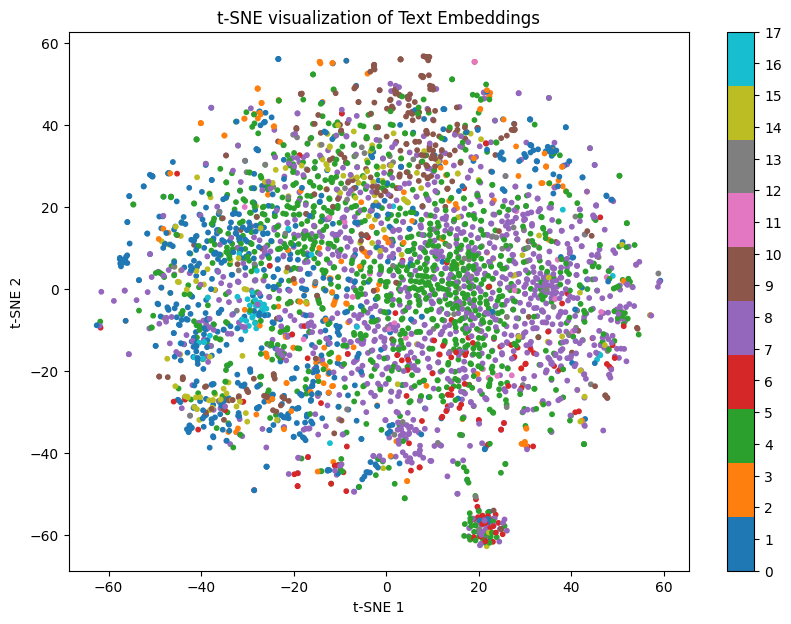

In [77]:
# Assuming text_emb is your 3882x768 matrix (text embeddings)
# Initialize t-SNE model to reduce dimensions to 2D for visualization
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# Apply t-SNE on the text embeddings
text_emb_2d = tsne_model.fit_transform(text_emb.cpu())

# Step 5: Plot the t-SNE result, coloring by genre labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(text_emb_2d[:, 0], text_emb_2d[:, 1], c=df['Genre_Label'], s=10, cmap='tab10')  # 'tab10' color map for categorical data

# Add a color bar to represent the genres
plt.colorbar(scatter, ticks=range(len(df['Genre_Label'].unique())))
# # Plotting the 2D t-SNE result
# plt.figure(figsize=(10, 7))
# plt.scatter(text_emb_2d[:, 0], text_emb_2d[:, 1], s=10, cmap='viridis')
plt.title('t-SNE visualization of Text Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [84]:
for idx, genre_combination in enumerate(label_encoder.classes_):
    print(f"Label {idx}: {genre_combination}")

Label 0: Action
Label 1: Adventure
Label 2: Animation
Label 3: Children's
Label 4: Comedy
Label 5: Crime
Label 6: Documentary
Label 7: Drama
Label 8: Fantasy
Label 9: Film-Noir
Label 10: Horror
Label 11: Musical
Label 12: Mystery
Label 13: Romance
Label 14: Sci-Fi
Label 15: Thriller
Label 16: War
Label 17: Western
